In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

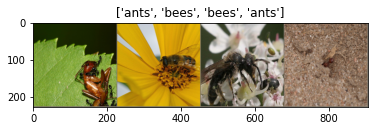

In [12]:
def imshow(inp, title=None):
    """tensor를 입력받아 일반적인 이미지로 보여줍니다."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [25]:
import copy

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [26]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5308 Acc: 0.6996
val Loss: 0.2214 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4074 Acc: 0.8313
val Loss: 0.2999 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.7920 Acc: 0.7243
val Loss: 0.3483 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4390 Acc: 0.8395
val Loss: 0.5868 Acc: 0.8235

Epoch 4/24
----------
train Loss: 0.5916 Acc: 0.7695
val Loss: 0.3359 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4744 Acc: 0.8354
val Loss: 0.4951 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.4144 Acc: 0.8601
val Loss: 0.2799 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3232 Acc: 0.8642
val Loss: 0.2314 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.4858 Acc: 0.7984
val Loss: 0.2334 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3563 Acc: 0.8601
val Loss: 0.2083 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2840 Acc: 0.8889
val Loss: 0.2178 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3531 Acc: 0.8477
val Loss: 0.1986 Acc: 0.9216

Ep

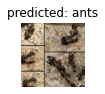

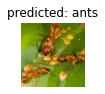

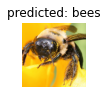

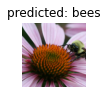

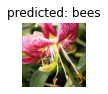

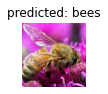

In [27]:
visualize_model(model_ft)


In [28]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [29]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5361 Acc: 0.6831
val Loss: 0.2325 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.3821 Acc: 0.8477
val Loss: 0.2261 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.6137 Acc: 0.7284
val Loss: 0.5010 Acc: 0.8039

Epoch 3/24
----------
train Loss: 0.3613 Acc: 0.8519
val Loss: 0.2067 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4063 Acc: 0.8313
val Loss: 0.2357 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.5924 Acc: 0.7901
val Loss: 0.3002 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.6571 Acc: 0.7407
val Loss: 0.2330 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3275 Acc: 0.8560
val Loss: 0.1847 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4396 Acc: 0.8148
val Loss: 0.1709 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3728 Acc: 0.8436
val Loss: 0.1705 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.4210 Acc: 0.8272
val Loss: 0.1928 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3228 Acc: 0.8601
val Loss: 0.1844 Acc: 0.9412

Ep

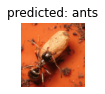

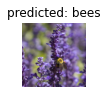

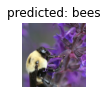

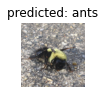

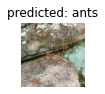

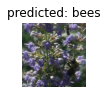

In [30]:
visualize_model(model_conv)

plt.ioff()
plt.show()